In [1]:
import sys
import random
import copy
from collections import defaultdict
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext Cython

In [2]:
env = gym.make('Blackjack-v0', natural=True)

### 1. Самая простая стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit

In [3]:
# стратегия строго детерминирована
def policy_0(state):
    if state[0] >= 19:
        action = 0
    else:
        action = 1
    return action

def generate_episode(policy):
    episode = []
    state = env.reset()
    while True:
        action = policy(state)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

# поэтому рассчитаем V и оценим выйгрыш стратегией при помощи данной функции
def mc_policy_evaluation(policy, n_episodes=100_000, gamma=1.):
    # необходимо для рассчета V
    returns_sum = defaultdict(float)
    N = defaultdict(int)
    V = defaultdict(float)
    
    # точки необходимые для графика, точки mean_reward    
    mean_rewards, iters = [], []
    sum_reward = 0
    
    for i in range(1, n_episodes+1):
        episode = generate_episode(policy)
        # разворачиваем, так удобнее считать return G
        episode.reverse()
                
        # записываем точки для графика
        sum_reward += episode[0][2]
        if i%(n_episodes//10) == 0:  # отрезок делим на 10 частей
            mean_rewards.append(sum_reward/i)
            iters.append(i)
        
        G = 0
        for state, action, reward in episode:
            G = gamma * G + reward
            # every-visit
            returns_sum[state] += G
            N[state] += 1
            V[state] = returns_sum[state] / N[state]

    return V, [iters, mean_rewards]

def plot_reward(*points):
    plt.rcParams["font.size"] = "16" 
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor("seashell")
    plt.ylabel("mean reward")
    plt.xlabel("iteration")
    for i in points:
        plt.plot(i[0], i[1])
    ax.set_yticks([-.3, -.25, -0.2, -.15, -.1, -.05, 0., .05])
    ax.grid()
    plt.show()

mean reward =  -0.17881


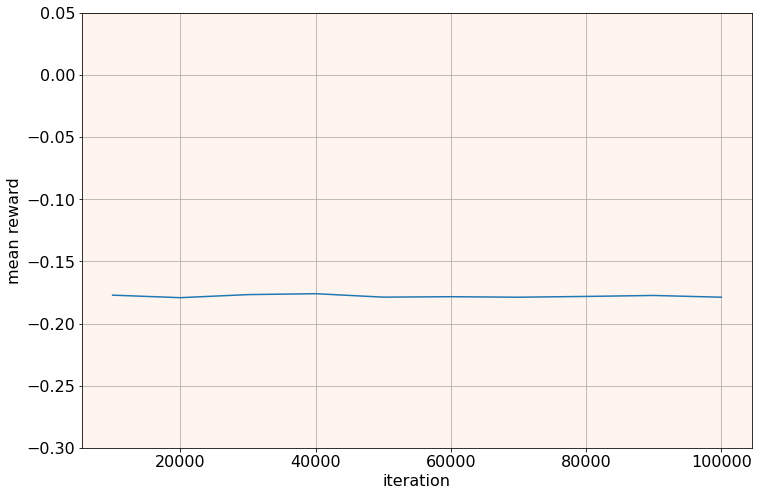

In [4]:
# mean reward for policy_0
V, plot_points = mc_policy_evaluation(policy_0)
print('mean reward = ', plot_points[-1][-1])
plot_reward(plot_points)

горизонтальная прямая объяснима тем, что мы не обучали стратегию, а использовали детерменированную

### 2. обучаем стратегию при помощи Monte Carlo control every-visit

In [5]:
def decay_epsilon_gen(min_epsilon=.01, decay=0.99999, **kwargs): # let's use epsilon decay
    epsilon = 1
    while epsilon > min_epsilon:
        yield epsilon
        epsilon = epsilon*decay
    while True:
        yield min_epsilon

def treshold_epsilon_gen(n_episodes, min_epsilon=.01, **kwargs): # 2 stages -> 80% / 20%
    i = 0  # сначала epsilon всегда 1, потом всегда min
    # то есть мы обучаем алгоритм первые 8 частей, а последние две уже просто смотрим  награду
    while i < n_episodes*.8:
        yield 1
        i += 1
    while True:
        yield min_epsilon

def const_epsilon(*args, **kwargs):
    if "min_epsilon" in kwargs:
        epsilon = kwargs['min_epsilon']
    elif "epsilon" in kwargs:
        epsilon = kwargs['epsilon']
    else:
        epsilon = .01
    while True:
        yield epsilon

In [45]:
def policy_1(Q_s, epsilon):
    """эпсилон-жадная стратегия, выбирает действие основываясь на Q[state]
    
    может выбрать случайное действие с вероятностью epsilon/число_действий
    и жадное действие с вероятностью   1-epsilon + epsilon/число_действий
    либо можно сначала кинуть roll на жадное действие с вероятностью 1-epsilon
    если не выпадет, то выбрать действие случайно между всеми,
    вторая реализация работает на порядок быстрее
    """
    An = len(Q_s)
    if epsilon != 1 and random.random() > epsilon:
        action = np.argmax(Q_s)
    else:
        action = random.randint(0, An-1)
    return action

def generate_stochastic_episode(policy, Q, epsilon):
    episode = []
    state = env.reset()
    while True:
        action = policy(Q[state], epsilon)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def mc_control_q(policy, eps_generator, Q=None, n_episodes=600_000, gamma=.8, lr_n=0, **kwargs):
    if Q is None:
        Q = defaultdict(lambda: np.random.rand(env.action_space.n))
    N = defaultdict(lambda: [0]*env.action_space.n)
    
    eps_gen = eps_generator(n_episodes=n_episodes, **kwargs)
    # необходимо для графика, точки mean_reward    
    sum_reward = 0
    mean_rewards, iters, eps_history = [], [], []
    
    for i in range(1, n_episodes+1):
        epsilon = next(eps_gen)
        episode = generate_stochastic_episode(policy, Q, epsilon)
        # разворачиваем, так удобнее считать return
        episode.reverse()
        
        # записываем точки для графика       
        sum_reward += episode[0][2]
        if i%(n_episodes//10) == 0:
            mean_rewards.append(sum_reward/(n_episodes//10))
            sum_reward = 0
            iters.append(i)
            eps_history.append(epsilon)
        
        G = 0
        # every-visit
        for state, action, reward in episode:
            G = gamma * G + reward
            
            N[state][action] += 1
            learning_rate = 1/(N[state][action]+lr_n) # lr_n нужно для возможности дообучиться
            
            Q[state][action] += learning_rate*(G - Q[state][action])
            # стоит помнить что изменяем Q, которое подали в аргументы
    return iters, mean_rewards, eps_history

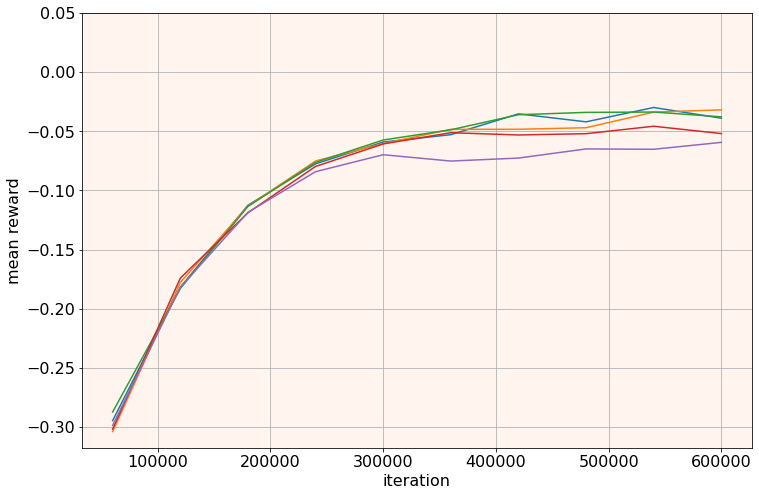

CPU times: user 2min, sys: 832 ms, total: 2min 1s
Wall time: 2min


In [7]:
%%time
env = gym.make('Blackjack-v0', natural=True) # standart BJ

# подбираем min_epsilon
min_epsilon_plot_points = [mc_control_q(
                              policy_1,
                              decay_epsilon_gen,
                              min_epsilon=x)
                           for x in [.001, .005, .01, .05, .1]]
plot_reward(*min_epsilon_plot_points)

три графика идут вместе, и два расходятся раньше<br>min_epsilon имеет смысл выбирать максимальным из тех, при которых не страдает reward<br>в данном случае это 0.01

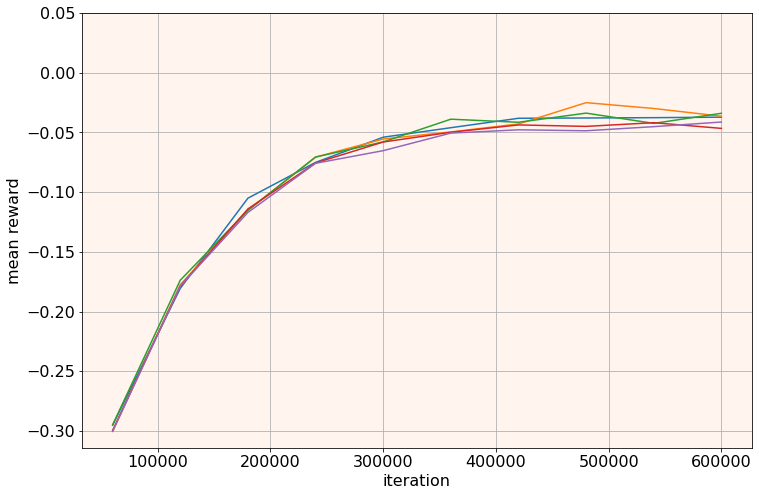

CPU times: user 2min 2s, sys: 935 ms, total: 2min 3s
Wall time: 2min 1s


In [8]:
%%time
env = gym.make('Blackjack-v0', natural=True) # standart BJ

# подбираем gamma
gamma_plot_points = [mc_control_q(
                        policy_1,
                        decay_epsilon_gen,
                        gamma=x,
                        min_epsilon=0.01)
                    for x in [.01, .1, .5, .9, .99]]
plot_reward(*gamma_plot_points)

вывод - гамма в данном случае влияет несущественно

mean reward =  -0.04056666666666667


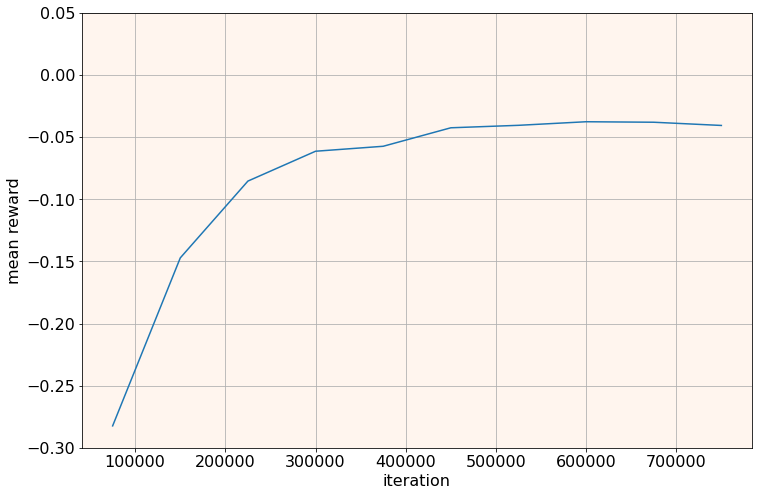

CPU times: user 30.5 s, sys: 344 ms, total: 30.9 s
Wall time: 30.3 s


In [18]:
%%time
env = gym.make('Blackjack-v0', natural=True) # standart BJ

plot_points = mc_control_q(policy_1, decay_epsilon_gen, n_episodes=750_000)
print('mean reward = ', plot_points[1][-1])
plot_reward(plot_points)

In [19]:
plot_points[1] # сошлось приблизительно на восьмой точке

[-0.28236,
 -0.14716666666666667,
 -0.08534,
 -0.06132,
 -0.057326666666666665,
 -0.04244666666666667,
 -0.04046,
 -0.03758,
 -0.03798,
 -0.04056666666666667]

In [20]:
plot_points[0][7] # при этом было 600_000 итераций

600000

In [17]:
plot_points[2] # эпсилон сошлось в 0.01 уже на четвертой точке

[0.22313071797605036,
 0.04978681943133514,
 0.011108857675770425,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01]

итого:<br>
выбрали min_epsilon<br>
влияние гаммы в данном случае несущественно<br>
дольше 600_000 итераций обучаться уже не помогает улучшить результат<br>
decay coefficient - помогает сделать больше exploration, однако повышать его смысла нет, потому что таким образом мы будем тратить много времени на стратегии, далекие от оптимальной, соответственно при большом decay coeff нужно ставить большие значения n_episodes. 

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [21]:
import gym.envs.toy_text.blackjack as bj

class BlackjackDoubleEnv(gym.Env):
    def __init__(self, natural=True):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
обратная сторона
        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(bj.draw_card(self.np_random))
            if bj.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
                
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while bj.sum_hand(self.dealer) < 17:
                self.dealer.append(bj.draw_card(self.np_random))
            reward = bj.cmp(bj.score(self.player), bj.score(self.dealer))
            if self.natural and bj.is_natural(self.player) and reward == 1.:
                reward = 1.5
    
        elif action == 2: # double: add a card and x2 reward
            self.player.append(bj.draw_card(self.np_random))
            done = True
            if bj.is_bust(self.player):
                reward = -2.
            else:
                while bj.sum_hand(self.dealer) < 17:
                    self.dealer.append(bj.draw_card(self.np_random))
                reward = bj.cmp(bj.score(self.player), bj.score(self.dealer)) * 2
                
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (bj.sum_hand(self.player), self.dealer[0], bj.usable_ace(self.player))

    def reset(self):
        self.dealer = bj.draw_hand(self.np_random)
        self.player = bj.draw_hand(self.np_random)
        return self._get_obs()

In [22]:
env = BlackjackDoubleEnv()
env.action_space.n

3

In [23]:
state = env.reset()
state

(16, 8, False)

In [24]:
env.step(2) # работает!

((21, 8, False), 2.0, True, {})

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

mean reward =  -0.03175416666666667


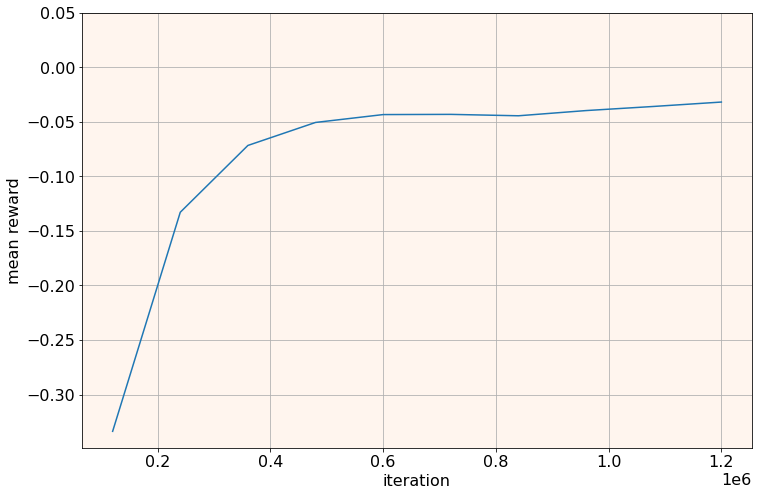

CPU times: user 48.1 s, sys: 672 ms, total: 48.8 s
Wall time: 47.8 s


In [26]:
%%time
env = BlackjackDoubleEnv() # BJ with double
Q_double = defaultdict(lambda: np.random.rand(env.action_space.n)) # обученный Q будем использовать далее

plot_points = mc_control_q(policy_1, decay_epsilon_gen, Q=Q_double, n_episodes=1_200_000)
print('mean reward = ', plot_points[1][-1])
plot_reward(plot_points)

результат c double кажется незначительно лучше, но это не точно :)

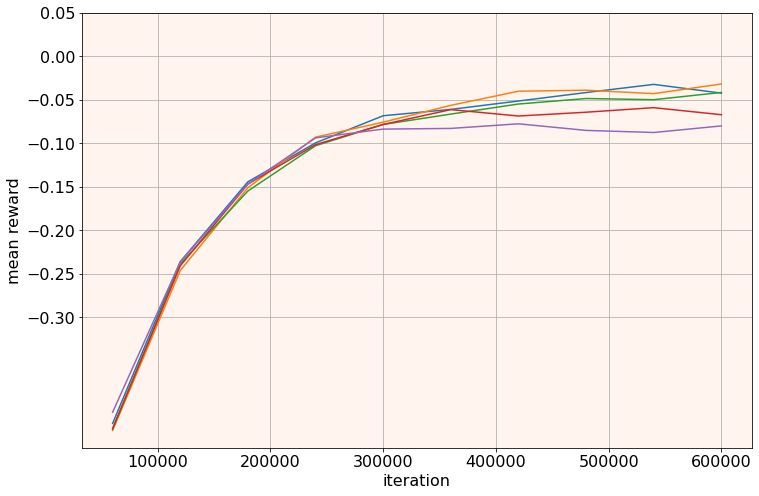

CPU times: user 1min 57s, sys: 744 ms, total: 1min 58s
Wall time: 1min 57s


In [29]:
%%time
env = BlackjackDoubleEnv() # BJ with double
# подбираем min_epsilon
min_epsilon_plot_points = [mc_control_q(
                        policy_1,
                        decay_epsilon_gen,
                        min_epsilon=x)
                    for x in [.001, .005, .01, .05, .1]]
plot_reward(*min_epsilon_plot_points)

аналогично обычному Джеку, оптимальный min_epsilon = 0.01

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами;
итак, самый простой и эффективный способ считать карты - хранить число вышедших карт, для этого создадим две переменные - opened и closed. Первая - список известных карт, например opened[0] - число вышедших тузов, а opened[3] - число вышедших десяток (и картинок). Вторая переменная - какая карта у дилера скрыта, добавляем ее в opened после окончания партии. closed = 1 - это туз, closed = 10 - это карта дающая 10 очков.

In [30]:
# Q можно дообучить стратегию, полученную на предыдущем шаге, потому что число состояний на порядки больше
class DictQ(dict):
    def __missing__(self, state):
        
        old_state = (state[-3], state[-2], state[-1])
        self[state] = Q_double[old_state].copy()
        return self[state]

# новый Q будет создаваться вот так: Q_count = DictQ()

In [37]:
class BlackjackDoubleCountEnv(gym.Env):
    def __init__(self, natural=True):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(5), # aces
            spaces.Discrete(17), # 2-5 аггрегируем некоторые карты, чтобы уменьшить число состояний
            spaces.Discrete(17), # 6-9
            spaces.Discrete(17), # кард дающих 10 очков может выйти 0, а может 16, итого 17 значений
            
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.orig_deck = sorted([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4)
        self.deck = copy.copy(self.orig_deck)
        self.opened = [0]*4
        self.closed = 0
        
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
                
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
            if self.natural and self.is_natural(self.player) and reward == 1.:
                reward = 1.5
    
        elif action == 2: # double: add a card and x2 reward
            self.player.append(self.draw_card(self.np_random))
            done = True
            if self.is_bust(self.player):
                reward = -2.
            else:
                while self.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = self.cmp(self.score(self.player), self.score(self.dealer)) * 2
        
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (*self.opened, self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def reset(self, full_reset=False):
        if full_reset or len(self.deck) < 15:
            self.deck = copy.copy(self.orig_deck)
            self.opened = [0]*4
            self.closed = 0
        elif self.closed: # теперь знаем закрытую карту дилера с прошлого хода
            if self.closed == 1:
                i = 0
            elif 2 <= self.closed <= 5:
                i = 1
            elif 6 <= self.closed <= 9:
                i = 2
            elif self.closed == 10:
                i = 3
            else:
                assert False            
            self.opened[i] += 1 # добавим ее в увиденные карты
        self.dealer = self.draw_dealer_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()
    
    def cmp(self, a, b):
        return float(a > b) - float(a < b)

    def draw_card(self, np_random):
        card = self.deck.pop(random.randrange(len(self.deck)))
        if card == 1:
            i = 0
        elif 2 <= card <= 5:
            i = 1
        elif 6 <= card <= 9:
            i = 2
        elif card == 10:
            i = 3
        else:
            assert False            
        self.opened[i] += 1 
        return card
    
    def draw_closed(self, np_random):
        card = self.deck.pop(random.randrange(len(self.deck)))
        self.closed = card
        return card

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def draw_dealer_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_closed(np_random)]

    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21

    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21

    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]

In [38]:
env = BlackjackDoubleCountEnv()
print(env.action_space.n)
Q_count = DictQ()

3


In [39]:
generate_stochastic_episode(policy_1, Q_count, .05)

[((1, 1, 3, 2, 20, 9, False), 0, 1.0)]

In [32]:
sum(plot_points[1][-5:])/5 # 400

-0.03685098

mean reward =  -0.018535233333333335


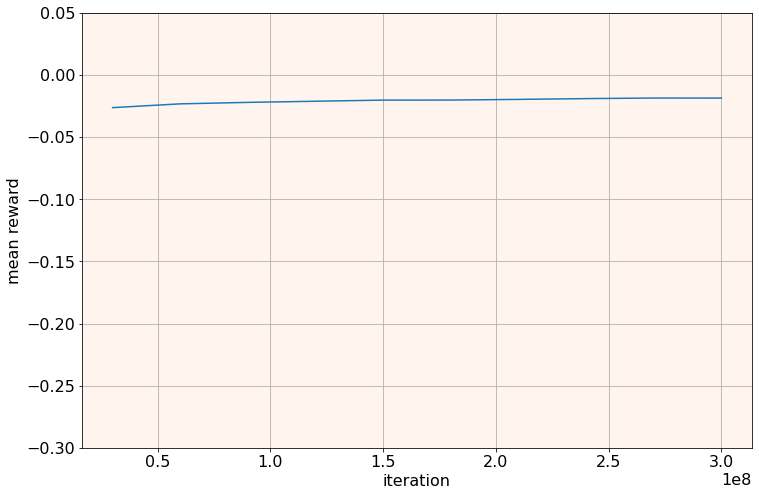

CPU times: user 1h 41min 58s, sys: 38.9 s, total: 1h 42min 36s
Wall time: 1h 41min 47s


In [46]:
%%time
env = BlackjackDoubleCountEnv() # BJ with count
Q_count = DictQ()
plot_points = mc_control_q(policy_1, const_epsilon, Q=Q_count, n_episodes=300_000_000,lr_n=40)
print('mean reward = ', plot_points[1][-1])
plot_reward(plot_points)
plot_points100 = plot_points

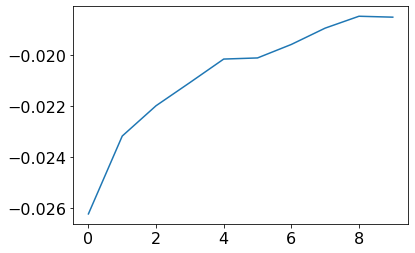

In [47]:
plt.plot(plot_points[1])

In [48]:
plot_points[1]

[-0.02622135,
 -0.023179366666666666,
 -0.021995,
 -0.0210908,
 -0.020172,
 -0.02012805,
 -0.019600933333333334,
 -0.018963466666666668,
 -0.0184991,
 -0.018535233333333335]

Считая карты мы увеличили reward c -0.03175416666666667 до -0.018535233333333335. и возможно это не предел.